# Investment Game
The rules of the investment game are outlined in the `README.md`. Here we are implementing a simple environment in order to play the game.

In [1]:
import numpy as np
import gym

## Time-series for assets

In [33]:
import seaborn as sns
import pandas as pd
sns.set()

/home/malte/anaconda3/envs/rl-invest/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/malte/anaconda3/envs/rl-invest/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [34]:
# creating artificial time-series data
rounds = np.arange(20)

<AxesSubplot:xlabel='x', ylabel='y'>

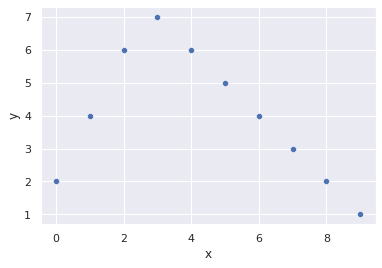

In [35]:
x = np.arange(10)
y = np.piecewise(x, [x < 3, x >= 3], [lambda y_: 2*y_+2, lambda y_: -1*y_+10])

df = pd.DataFrame({'x': x, 'y': y})
sns.scatterplot(data=df, x='x', y='y')


## Game environment

In [ ]:
class InvestmentGame(gym.Env):
    def __init__(self):
        self.num_rounds = 20
        self.num_initial_chips = 100